In [ ]:
!pip install transformers torch matplotlib wordcloud

In [4]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


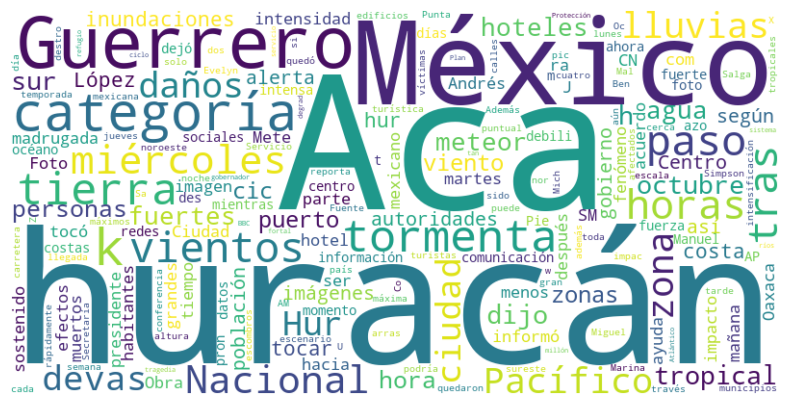

In [3]:
import json
import torch
from transformers import BertTokenizer, BertModel
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Cargar las stopwords en español
stop_words = set(stopwords.words('spanish'))

# Función para limpiar tokens
#def limpiar_tokens(tokens):
#    return [token for token in tokens if token.lower() not in stop_words and token.isalpha()]

def limpiar_tokens(tokens):
    palabras_limpias = []
    for token in tokens:
        if token.lower() not in stop_words and token.isalpha():
            palabras_limpias.append(token)
        elif token.lower() == 'acapulco':  # Asegurarnos de incluir "Acapulco"
            palabras_limpias.append(token)
    return palabras_limpias


# Cargar el modelo preentrenado y el tokenizador
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Archivo JSONL de entrada
archivo_path = './02_news/noticias_huracan_otis.jsonl'

# Leer el archivo y procesar los textos
palabras_ponderadas = Counter()

with open(archivo_path, 'r', encoding='utf-8') as file:
    for linea in file:
        noticia = json.loads(linea)
        texto = noticia['content']

        # Tokenizar el texto
        inputs = tokenizer(texto, return_tensors='pt', truncation=True, max_length=512)

        # Obtener los embeddings del modelo
        with torch.no_grad():
            outputs = model(**inputs)

        # Obtener la última capa oculta de los embeddings
        last_hidden_states = outputs.last_hidden_state

        # Calcular la media de los embeddings para obtener el vector representativo del texto
        texto_embedding = last_hidden_states.mean(dim=1).squeeze()

        # Convertir a numpy y listar las palabras más representativas
        texto_embedding_np = texto_embedding.numpy()
        palabras = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        # Limpiar los tokens
        palabras_limpias = limpiar_tokens(palabras)

        for palabra in palabras_limpias:
            palabras_ponderadas[palabra] += 1  # Esto sigue siendo una simplificación


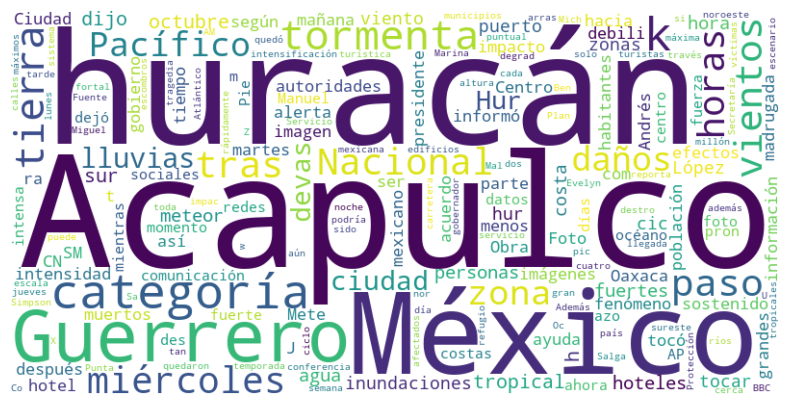

In [9]:
# Reemplazar 'Aca' con 'Acapulco'
if 'Aca' in palabras_ponderadas:
    palabras_ponderadas['Acapulco'] = palabras_ponderadas.pop('Aca')

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palabras_ponderadas)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [10]:
from wordcloud import WordCloud
import os

# Asegurarse de que la carpeta de destino existe, si no, crearla
directory = "./02_news/wordcloud_news"
if not os.path.exists(directory):
    os.makedirs(directory)

# Supongamos que 'palabras_ponderadas' es el Counter actualizado con 'Acapulco'
# Doblar el tamaño de la imagen de la nube de palabras
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(palabras_ponderadas)

# Guardar la imagen de la nube de palabras
wordcloud.to_file(os.path.join(directory, 'wordcloud.jpeg'))

# Ahora, para guardar la lista de palabras ordenada:
palabras_ordenadas = palabras_ponderadas.most_common()

# Guardar la lista en un archivo de texto
with open(os.path.join(directory, 'palabras_ponderadas.txt'), 'w') as file:
    for palabra, frecuencia in palabras_ordenadas:
        file.write(f'{palabra}: {frecuencia}\n')

